# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

----
----

Project by:
- Tian Cheng Xia
- Luca Domeniconi

## Initialization

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image, ImageDraw
from sklearn.linear_model import LinearRegression
from itertools import combinations
from sklearn.cluster import KMeans
from enum import Enum
from typing import Optional
import logging
logger = logging.getLogger(__name__)

### Configuration variables

In [2]:
DATASET_DIR = "./dataset"
TEMPLATES_DIR_NAME = "models"
SCENES_DIR_NAME = "scenes"
TEMPLATES_FILE_NAME = "ref{index}.png"
SCENE_FILE_NAME = "scene{index}.png"

SINGLE_INSTANCE_TEMPLATE_IDXS = [ *range(1, 15) ]
SINGLE_INSTANCE_SCENE_IDXS = [ *range(1, 6) ]
MULTIPLE_INSTANCES_TEMPLATE_IDXS = [ *range(15, 28) ]
MULTIPLE_INSTANCES_SCENE_IDXS = [ *range(6, 13) ]

SHOW_PLOTS = True
logging.basicConfig(level=logging.INFO)

### Loading images

In [3]:
def loadImage(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

template_dir = os.path.join(DATASET_DIR, TEMPLATES_DIR_NAME)
scene_dir = os.path.join(DATASET_DIR, SCENES_DIR_NAME)

single_instance_templates = [ loadImage( os.path.join(template_dir, TEMPLATES_FILE_NAME.format(index=i)) ) for i in SINGLE_INSTANCE_TEMPLATE_IDXS ]
single_instance_scenes = [ loadImage( os.path.join(scene_dir, SCENE_FILE_NAME.format(index=i)) ) for i in SINGLE_INSTANCE_SCENE_IDXS ]
multi_instance_templates = [ loadImage( os.path.join(template_dir, TEMPLATES_FILE_NAME.format(index=i)) ) for i in MULTIPLE_INSTANCES_TEMPLATE_IDXS ]
multi_instance_scenes = [ loadImage( os.path.join(scene_dir, SCENE_FILE_NAME.format(index=i)) ) for i in MULTIPLE_INSTANCES_SCENE_IDXS ]

single_instance_ground_truth = {
    1: {1: 1, 2: 1},
    2: {3: 1, 4: 1, 5: 1},
    3: {6: 1, 7: 1, 8: 1},
    4: {1: 1, 7: 1, 8: 1, 9: 1, 10: 1},
    5: {11: 1, 12: 1}
}

multi_instance_ground_truth = {
    6: { 15: 2 },
    7: { 16: 2 },
    8: { 17: 2, 23: 2, 24: 1, 27: 1 },
    9: { 18: 2, 19: 2, 20: 2 },
    10: { 21: 2, 22: 2 },
    11: { 17: 2, 23: 2, 24: 2, 25: 3 },
    12: { 26: 2, 27: 2, 18: 2 }
}

FLANN_INDEX_KDTREE = 1

### Simple evaluation function

In [4]:
def evaluate(prediction, ground_truth):
    corrects = { idx: 0 for idx in prediction.keys() }
    mistakes = { idx: 0 for idx in prediction.keys() }
    missing = { idx: 0 for idx in prediction.keys() }
    exceedings = { idx: 0 for idx in prediction.keys() }

    for scene_idx, preds in prediction.items():
        for template_idx, num_instances in ground_truth[scene_idx].items():
            if template_idx not in preds:
                missing[scene_idx] += num_instances
            elif preds[template_idx] < num_instances:
                missing[scene_idx] += num_instances - preds[template_idx]
                corrects[scene_idx] += preds[template_idx]
            elif preds[template_idx] > num_instances:
                exceedings[scene_idx] += preds[template_idx] - num_instances
                corrects[scene_idx] += num_instances
            else:
                corrects[scene_idx] += num_instances

        for template_idx, num_detections in preds.items():
            if template_idx not in ground_truth[scene_idx]:
                mistakes[scene_idx] += num_detections

    for scene_idx in prediction.keys():
        logger.info(
            f"Correctness scene{scene_idx}: {corrects[scene_idx]}/{sum([*ground_truth[scene_idx].values()])} "
            f"({mistakes[scene_idx]} mistakes, {missing[scene_idx]} missing, {exceedings[scene_idx]} exceedings)"
        )

### Utility functions

In [5]:
def matchKeypoints(
        scene, 
        template, 
        sift_params = { "contrastThreshold": 0.015 }, 
        flann_params = {
            "indexParams": { "algorithm": FLANN_INDEX_KDTREE, "trees": 5 },
            "searchParams": { "checks": 300 }
        }
    ):
    sift = cv2.SIFT_create(**sift_params)
    flann = cv2.FlannBasedMatcher(**flann_params)

    # Find and match keypoints
    kp_template = sift.detect(template)
    kp_template, desc_template = sift.compute(template, kp_template)
    kp_scene = sift.detect(scene)
    kp_scene, desc_scene = sift.compute(scene, kp_scene)

    matches = flann.knnMatch(desc_template, desc_scene, k=2)
    return kp_template, kp_scene, matches


def clampVertexes(vertexes, image):
    """
        Fits the coordinates of a polygon within an image.
    """
    vertexes = vertexes.copy()
    for i in range(len(vertexes)):
        vertexes[i] = (max(0, min(vertexes[i][0], image.shape[1]-1)), max(0, min(vertexes[i][1], image.shape[0]-1)))
    return vertexes
    

def applyPolygonalMask(image, polygon_vertexes, inplace=False):
    """
        Sets, in the input image, an area defined by a polygon to 0.
    """
    if not inplace: image = image.copy()
    
    image_mask = Image.new("L", (image.shape[1], image.shape[0]), 0)
    ImageDraw.Draw(image_mask).polygon([
        (max(0, int(pt[0])), max(0, int(pt[1]))) for pt in polygon_vertexes
    ], outline=1, fill=1)
    mask = np.array(image_mask)
    image[ mask == 1, : ] = 0

    return image


def formatResultBox(object_vertexes):
    """
        Format the resulting polygonal bounding box to make it a rectangle.
        Assuming that the polygon is rectangle-like, the output box is obtained by
        averaging across all the axes.
    """
    top_left = object_vertexes[0]
    bottom_left = object_vertexes[1]
    bottom_right = object_vertexes[2]
    top_right = object_vertexes[3]

    left_x_mean = int( (top_left[0] + bottom_left[0]) / 2 )
    right_x_mean = int( (top_right[0] + bottom_right[0]) / 2 )
    top_y_mean = int( (top_left[1] + top_right[1]) / 2 )
    bottom_y_mean = int( (bottom_left[1] + bottom_right[1]) / 2 )

    return (left_x_mean, top_y_mean), right_x_mean-left_x_mean, bottom_y_mean-top_y_mean


def printResults(scene_idx, template_idx, bounding_boxes):
    print(f"Product {template_idx} - Scene {scene_idx} - {len(bounding_boxes)} instance found:")
    for i, polygon in enumerate(bounding_boxes):
        top_left, width, height = formatResultBox(polygon)
        print( f"Instance {i+1} {{position: {top_left}, width: {width}px, height: {height}px}}" )


def getRandomColor(idx):
    colors = "rgbcmk"
    return colors[ idx % len(colors) ]

## Image filtering

We tested various combinations of filters following the rule-of-thumb of 
using a a median filter to remove salt-and-pepper noise followed by a filter to remove Gaussian noise.

In [6]:
def filterKeypoints(image):
    image = cv2.medianBlur(image, 9)
    image = cv2.bilateralFilter(image, d=-1, sigmaColor=25, sigmaSpace=15)
    return image


def filterColor(image):
    image = cv2.medianBlur(image, 9)
    image = cv2.bilateralFilter(image, d=-1, sigmaColor=30, sigmaSpace=15)
    return image

## Candidate matches detection

### Density coverage computation

To address the issue of instances that only partially match the template (e.g., the same title on a cereal box but with a different lower part), we implemented a strategy that goes beyond simply counting the number of matches. We subdivide the template into several parts and then count how many of these parts have at least one match. 

This method ensures that a partially matched template yields a lower match score, even if the total number of matches is high. To capture the fact that some part of the image might have denser keypoints, we base the splits on the density of detected SIFT keypoints.

In [7]:
# Splits the given rect in 4 rect if there are at least k points inside it 
def split_rect(rect, points, k=5, max_depth=4):
    # Rect is a tuple of 4 points
    # rect = (upper_right, upper_left, lower_left, lower_right)
    rects = []
    
    y_min, y_max = rect[3][1], rect[0][1]
    x_min, x_max = rect[1][0], rect[0][0]
    y_med, x_med = (y_max + y_min)/2, (x_max + x_min)/2
    
    inside_points = [p for p in points if p[0] >= x_min and p[0] <= x_max and p[1] >= y_min and p[1] <= y_max]
    if len(inside_points) == 0:
        return None
    
    if max_depth == 0:
        return []
    
    if len(inside_points) > k:
        upper_right_rect = ((x_max, y_max), (x_med, y_max), (x_med, y_med), (x_max, y_med))
        upper_left_rect = ((x_med, y_max), (x_min, y_max), (x_min, y_med), (x_med, y_med))
        lower_left_rect = ((x_med, y_med), (x_min, y_med), (x_min, y_min), (x_med, y_min))
        lower_right_rect = ((x_max, y_med), (x_med, y_med), (x_med, y_min), ((x_max, y_min)))
                
        upper_right_split = split_rect(upper_right_rect, points, k, max_depth-1)
        upper_left_split = split_rect(upper_left_rect, points, k, max_depth-1)
        lower_left_split = split_rect(lower_left_rect, points, k, max_depth-1)
        lower_right_split = split_rect(lower_right_rect, points, k, max_depth-1)

        for s,r in [(upper_right_split, upper_right_rect), (upper_left_split, upper_left_rect), (lower_left_split, lower_left_rect), (lower_right_split, lower_right_rect)]:
            if s is not None:
                if len(s) > 0:
                    rects += s
                else:
                    rects += [r]
            
    return rects

![Alt text](https://i.ibb.co/fG7cwHj/output.png)

As illustrated in the image above, we count the number of regions that match the template, disregarding the size of the region. Our splitting algorithm ensures that each region contains a roughly equal number of keypoints.

In [8]:
def getDensity(matched_kp:list[tuple[float, float]], template_partition:list):
    """
        Returns the percentage of the template partitions that have been matched by at least one keypoint.
    """
    match_count = { s: 0 for s in template_partition }
    
    for x_kp, y_kp in matched_kp:
        for section in template_partition:
            (x_max, y_max), (_, _), (x_min, y_min), (_, _) = section
            if (x_min <= x_kp <= x_max) and (y_min <= y_kp <= y_max):
                match_count[section] += 1
                break

    return sum([1 for s in template_partition if match_count[s] > 0]) / len(template_partition)


def generateTemplateDensitySplits(template, contrast_th_start, contrast_th_step, edge_th_start, edge_th_step, split_k, split_depth):
    """
        Partitions an image based on its keypoints density.
    """
    contrastThreshold = contrast_th_start
    edgeThreshold = edge_th_start
    splitted_template = None

    while (splitted_template is None) or (len(splitted_template) == 0):
        sift_template_split = cv2.SIFT_create(
            contrastThreshold = contrastThreshold,
            edgeThreshold = edgeThreshold
        )
        h_template, w_template, _ = template.shape

        kp_template_rect = sift_template_split.detect(template)
        kp_template_rect, _ = sift_template_split.compute(template, kp_template_rect)
        splitted_template = split_rect(
            rect = ((w_template, h_template), (0, h_template), (0, 0), (w_template, 0)),
            points = [ (kp.pt[0], kp.pt[1]) for kp in kp_template_rect ],
            k = split_k,
            max_depth = split_depth
        )

        # If splitting is not possible, change SIFT parameters
        contrastThreshold += contrast_th_step
        edgeThreshold += edge_th_step

    return splitted_template

### Other match validation criteria

In [9]:
def polygonArea(points):
    x = np.array([ pt[0] for pt in points ])
    y = np.array([ pt[1] for pt in points ])
    return 0.5 * np.abs( (x @ np.roll(y,1)) - (y @ np.roll(x,1)) )


def areVertexesOverflowing(vertexes, image, tolerance_ratio):
    tolerance_x = image.shape[1] * tolerance_ratio
    tolerance_y = image.shape[0] * tolerance_ratio

    for point in vertexes:
        if ((point[0] > image.shape[1]+tolerance_x) or (point[0] < -tolerance_x) or 
            (point[1] > image.shape[0]+tolerance_y) or (point[1] < -tolerance_y)): 
            return True
    return False

## Color matching

In [10]:
def getColorFeatureAt(image, x, y, window_size):
    """
        Computes the mean color of a patch centered on (x, y)
    """
    x, y = int(x), int(y)
    step = window_size // 2
    return np.mean(image[y-step : y+step+1, x-step : x+step+1], axis=(0, 1))


def discretizeColorFeatures(color_features, n_bins=None):
    if n_bins is None: return color_features

    for i in range(color_features.shape[1]):
        clusterer = KMeans(n_clusters=n_bins, n_init="auto", random_state=42)
        # clusterer = KMedoids(n_clusters=n_bins, init="k-medoids++", random_state=42)
        clusters = clusterer.fit_predict( color_features[:, i].reshape(-1, 1) )
        
        for j in range(len(clusters)): color_features[j, i] = clusterer.cluster_centers_[ clusters[j] ][0]

    return color_features


def getColorFeatures(image, to_check_points, window_size, n_bins):
    color_features = []

    # Pad template and scene
    padding = window_size // 2
    padded_image = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_REFLECT)

    # Save color features at each interesting point
    for x, y in to_check_points:
        color = getColorFeatureAt(padded_image, x+padding, y+padding, window_size=window_size)
        color_features.append(color)
    color_features = np.array(color_features)

    # return discretizeColorFeatures(color_features, n_bins)
    return color_features

### Absolute color comparison

In [11]:
def getColorAbsoluteConfidence(color_features_template, color_features_scene, mask=None):
    """
        Compute the absolute confidence
    """
    X = np.array(color_features_template)
    y = np.array(color_features_scene)

    abs_diff = np.linalg.norm( X - y, np.inf, axis=1 )
    return np.mean(abs_diff[abs_diff > 25])

### Affine transformation detection

In [12]:
def getColorAffineConfidence(color_features_template, color_features_scene, mask=None):
    """
        Compute the affine transformation confidence
    """
    X = np.array(color_features_template)
    y = np.array(color_features_scene)
    abs_diff = np.linalg.norm( X - y, np.inf, axis=1 )

    X = X[abs_diff > 30]
    y = y[abs_diff > 30]

    scores = []
    for i in range(X.shape[1]):
        X_c = X[:, i].reshape(-1, 1)
        y_c = y[:, i]
        reg = LinearRegression().fit(X_c, y_c)
        scores.append(reg.score(X_c, y_c))

    return np.min(scores)

### Color scores computation

In [13]:
def getColorMatchConfidence(template, scene, scene_for_kp, homography_color, window_size, n_bins):
    h_template, w_template, _ = template.shape

    warped_scene = cv2.warpPerspective(scene, homography_color, (w_template, h_template))
    masked_template = np.where(warped_scene != 0, template, 0)
    warped_scene_for_kp = cv2.warpPerspective(scene_for_kp, homography_color, (w_template, h_template))


    kp_template, kp_scene, matches = matchKeypoints(
        warped_scene_for_kp, masked_template, 
        sift_params = { "contrastThreshold": 0.001 },
        flann_params = {
            "indexParams": { "algorithm": FLANN_INDEX_KDTREE, "trees": 5 },
            "searchParams": { "checks": 1000 }
        }
    )

    to_check_points_template = []
    to_check_points_scene = []
    for m, _ in matches:
        if (np.sqrt((kp_template[m.queryIdx].pt[0] - kp_scene[m.trainIdx].pt[0])**2 + (kp_template[m.queryIdx].pt[1] - kp_scene[m.trainIdx].pt[1])**2) <= 20):
            to_check_points_template.append(kp_template[m.queryIdx].pt)
            to_check_points_scene.append(kp_scene[m.trainIdx].pt )


    color_features_scene = getColorFeatures(warped_scene, to_check_points_scene, window_size, n_bins)
    color_features_template = getColorFeatures(masked_template, to_check_points_template, window_size, n_bins)

    confidence_affine = getColorAffineConfidence(color_features_template, color_features_scene)
    confidence_absolute = getColorAbsoluteConfidence(color_features_template, color_features_scene)

    return confidence_absolute, confidence_affine

## Template features pre-computation

Density and color features of the templates can be pre-computed in advance [...]

In [14]:
class TemplateFeatures:
    def __init__(
        self, template, 
        contrast_th_start=0.16, contrast_th_step=-0.02, edge_th_start=8.0, edge_th_step=0.5, split_k=3, split_depth=3, 
        color_window_size=15, color_bins=10, color_threshold=None
    ):
        self.image = template
        
        self.splits = generateTemplateDensitySplits(template, contrast_th_start, contrast_th_step, edge_th_start, edge_th_step, split_k, split_depth)

        self.color_window_size = color_window_size
        self.color_bins = color_bins
        self.color_threshold = color_threshold


    def matchDensity(self, matched_template_kp):
        return getDensity(matched_template_kp, self.splits)


    def matchColor(self, scene, scene_for_kp, homography_color):
        return getColorMatchConfidence(self.image, scene, scene_for_kp, homography_color, self.color_window_size, self.color_bins)

## Complete workflow

In [15]:
class MismatchReason(Enum):
    OVERFLOW = 1
    AREA = 2
    DENSITY_VERY_LOW = 3
    DENSITY = 4
    COLOR_VERY_LOW = 5
    COLOR = 6


def checkMismatch(
        object_vertexes, 
        scene, 
        template_features, 
        overflow_tol_ratio, 
        min_area_ratio, 
        density_threshold, 
        matched_template_points
    ):
    scene_area = scene.shape[0] * scene.shape[1]

    # The area of the polygon is too small.
    detected_full_area = polygonArea(object_vertexes)
    if detected_full_area < scene_area*min_area_ratio:
        logger.info(f"Invalid for area {detected_full_area:.4f} < {scene_area*min_area_ratio:.4f}")
        return MismatchReason.AREA

    # The vertexes of the polygon overflow too much from the borders of the image.
    if areVertexesOverflowing(object_vertexes, scene, overflow_tol_ratio): 
        logger.info(f"Invalid for overflow")
        return MismatchReason.OVERFLOW
    
    # The density of the points is too low.
    detected_positive_area = max( 1, polygonArea(clampVertexes(object_vertexes, scene)) )
    density_multiplier = detected_full_area / detected_positive_area # Multiplier to scale the density based on the visible area
    match_density = template_features.matchDensity(matched_template_points)
    if (match_density * density_multiplier) < density_threshold:
        logger.info(f"Invalid for density {match_density:.4f}*{density_multiplier:.4f} = {match_density*density_multiplier:.4f}")
        if (match_density * density_multiplier) < density_threshold*0.5:
            return MismatchReason.DENSITY_VERY_LOW 
        else: 
            return MismatchReason.DENSITY

    logger.info(f"Matched density: {match_density:.4f} * {density_multiplier:.4f} = {match_density*density_multiplier:.4f}")
    return None

In [16]:
class CandidateInstance:
    def __init__(self, vertexes, diff_score, affine_score):
        self.vertexes = vertexes
        self.diff_score = diff_score
        self.affine_score = affine_score

In [17]:
def findCandidateInstances(
        scene_for_keypoints: np.ndarray, 
        scene_for_color: np.ndarray, 
        template_features: TemplateFeatures,
        to_try_thresholds: list[float] = np.arange(0.7, 0.9, 0.05),
        overflow_tol_ratio: float = 0.2, 
        min_area_ratio: float = 0.05,
        density_threshold: float = 0.40,
        seed: int = 42
    ):
    """
        Parameters
        ----------
            scene : np.ndarray
                Scene in which the object should be found.

            template : np.ndarray
                Template of the object to match.
            
            to_try_thresholds : list[float]
                Threshold for the k-neighbors matching.

            overflow_tol_ratio : float
                TODO ...
            
            proj_min_area : float

            seed : int
                Random seed for non-deterministic functions.
        
        Returns
        -------
            object_vertexes : list[tuple[float, float]]
                Vertexes of the boundaries of the object in the scene.
    """

    cv2.setRNGSeed(seed)
    np.random.seed(seed)

    template = template_features.image
    h_template, w_template, _ = template.shape
    curr_threshold_idx = 0
    should_compute_keypoints = True
    candidates = []
    
    while True:
        if should_compute_keypoints:
            should_compute_keypoints = False
            kp_template, kp_scene, matches = matchKeypoints(scene_for_keypoints, template)

        good_matches = [ 
            m for m, n in matches 
            if m.distance < to_try_thresholds[curr_threshold_idx]*n.distance
        ]

        template_points = np.float32([ kp_template[m.queryIdx].pt for m in good_matches ]).reshape(-1, 2)
        scene_points = np.float32([ kp_scene[m.trainIdx].pt for m in good_matches ]).reshape(-1, 2)
        
        # Find the homography from template to scene
        try:
            homography, mask = cv2.findHomography(template_points, scene_points, cv2.RANSAC, ransacReprojThreshold=20.0)
            mask = mask[:, 0] == 1
            if homography is None: raise Exception("Homography not found")
        except:
            curr_threshold_idx += 1
            if curr_threshold_idx >= len(to_try_thresholds): break
            continue
            
        # Compute the vertexes of the matched object in the scene
        object_vertexes = cv2.perspectiveTransform(
            src = np.float32([ [0,0], [0,h_template-1], [w_template-1,h_template-1], [w_template-1,0] ]).reshape(-1, 1, 2), 
            m = homography
        )
        object_vertexes = [pt[0] for pt in object_vertexes]

        invalidity_reason = checkMismatch(
            object_vertexes, 
            scene_for_keypoints, 
            template_features, 
            overflow_tol_ratio, 
            min_area_ratio, 
            density_threshold, 
            template_points[mask, :], 
        )

        if invalidity_reason is not None:
            # Increase keypoints matching threshold
            curr_threshold_idx += 1
            if curr_threshold_idx >= len(to_try_thresholds): break

            if invalidity_reason in [ MismatchReason.DENSITY_VERY_LOW ]:
                # Mask the mismatched instance
                scene_for_keypoints = applyPolygonalMask(scene_for_keypoints, object_vertexes, inplace=True)
                should_compute_keypoints = True
        else:
            diff_score, affine_score = template_features.matchColor(
                scene_for_color, 
                scene_for_keypoints, 
                np.linalg.inv(homography)
            )
            candidates.append(
                CandidateInstance(
                    vertexes = object_vertexes,
                    diff_score = diff_score,
                    affine_score = affine_score
                )
            )

            # Mask the mismatched instance
            scene_for_keypoints = applyPolygonalMask(scene_for_keypoints, object_vertexes, inplace=True)
            should_compute_keypoints = True
        
    return candidates

In [18]:
def colorComparisonSingleInstance(
        candidates, 
        diff_hard_thr = 40, 
        diff_soft_thr = 50, 
        affine_thr = 0.75
    ):
    min_diff_idx = np.argmin([ c.diff_score for c in candidates ])
    min_diff_score = candidates[min_diff_idx].diff_score
    min_affine_score = candidates[min_diff_idx].affine_score

    if min_diff_score < diff_hard_thr:
        logger.info(f"Matched absolute color: {min_diff_score:.4f}")
        return candidates[min_diff_idx]
    elif (diff_hard_thr <= min_diff_score < diff_soft_thr) and (min_affine_score >= affine_thr):
        logger.info(f"Matched absolute color: {min_diff_score:.4f} | Affine {min_affine_score:.4f}")
        return candidates[min_diff_idx]
    else:
        logger.info(f"Invalid for color {min_diff_score:.4f} | {min_affine_score:.4f}")
        return None
    

def colorComparisonMultiInstance(
        candidates, 
        diff_hard_thr = 40, 
        diff_soft_thr = 50, 
        affine_thr = 0.75, 
        neighbor_hard_thr = 5, 
        neighbor_soft_thr = 10
    ):
    min_diff_idx = np.argmin([ c.diff_score for c in candidates ])
    min_diff_score = candidates[min_diff_idx].diff_score
    min_affine_score = candidates[min_diff_idx].affine_score
    detections = []

    if (diff_hard_thr <= min_diff_score < diff_soft_thr and min_affine_score < affine_thr) or (min_diff_score >= diff_soft_thr): 
        return []
    hard_threshold = min_diff_score + neighbor_hard_thr
    soft_threshold = min_diff_score + neighbor_soft_thr

    for candidate in candidates:
        if candidate.diff_score <= hard_threshold:
            logger.info(f"Matched color absolute score: {candidate.diff_score:.4f} | Affine: {candidate.affine_score:.4f}")
            detections.append(candidate)
        elif candidate.diff_score <= soft_threshold and candidate.affine_score >= affine_thr:
            logger.info(f"Matched color absolute score: {candidate.diff_score:.4f} | Affine: {candidate.affine_score:.4f}")
            detections.append(candidate)
    
    return detections

## Single instance detection

For the single instance detection task, we utilize the following workflow:

1. Calculate SIFT keypoints in both the scene and template images.
2. Identify candidate matches in the scene using k-nearest neighbors (KNN) search.
3. Apply four different criteria to filter out false positives:
    - Compute the density coverage of the matched keypoints in the template image and derive a confidence score based on this coverage. If the score falls below a specified threshold, discard the matched area in the scene and repeat from step 1. If the score is above the threshold, accept this match as the correct one.
    - Evaluate whether any vertices extend excessively beyond the image boundaries.
    - Assess if the area of the resulting match is too small.
    - Implement color-based criteria (TODO).


In [19]:
def singleInstanceDetection(scene_kp, scene_color, template_features):
    candidates = findCandidateInstances(
        scene_kp, scene_color, template_features,
        to_try_thresholds = np.arange(0.7, 0.8, 0.05)
    )
    if len(candidates) == 0: return None
    color_match = colorComparisonSingleInstance(candidates)
    
    return None if color_match is None else color_match.vertexes

### Results

In [20]:
single_templates_features = []
for template in single_instance_templates:
    single_templates_features.append(TemplateFeatures(template, color_window_size=31, color_bins=None))

INFO:__main__:Matched density: 0.9778 * 1.0000 = 0.9778
INFO:__main__:Invalid for density 0.3111*1.1240 = 0.3497
INFO:__main__:Invalid for density 0.3111*1.0032 = 0.3121
INFO:__main__:Invalid for density 0.3333*1.0068 = 0.3356
INFO:__main__:Matched absolute color: 30.8848


Product 1 - Scene 1 - 1 instance found:
Instance 1 {position: (10, 14), width: 803px, height: 1048px}


INFO:__main__:Matched density: 0.9245 * 1.0000 = 0.9245
INFO:__main__:Invalid for density 0.2264*1.0492 = 0.2376
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for density 0.2642*1.1934 = 0.3152
INFO:__main__:Matched absolute color: 30.5067


Product 2 - Scene 1 - 1 instance found:
Instance 1 {position: (846, 9), width: 802px, height: 1048px}


INFO:__main__:Invalid for area 2.4688 < 88430.4000
INFO:__main__:Invalid for area 5.5000 < 88430.4000
INFO:__main__:Invalid for area 0.1250 < 88430.4000
INFO:__main__:Product 3 - Scene 1 - No match found
INFO:__main__:Invalid for area 0.4062 < 88430.4000
INFO:__main__:Invalid for area 0.6562 < 88430.4000
INFO:__main__:Invalid for area 2.3125 < 88430.4000
INFO:__main__:Product 4 - Scene 1 - No match found
INFO:__main__:Invalid for density 0.2222*1.0116 = 0.2248
INFO:__main__:Invalid for density 0.2000*1.0523 = 0.2105
INFO:__main__:Invalid for area 0.1250 < 88430.4000
INFO:__main__:Product 5 - Scene 1 - No match found
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for area 31.6250 < 88430.4000
INFO:__main__:Invalid for overflow
INFO:__main__:Product 6 - Scene 1 - No match found
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for overflow
INFO:__main__:Product 7 - Scene 1 - No match found
INFO:__main__:Invalid for area 25383.5000 < 884

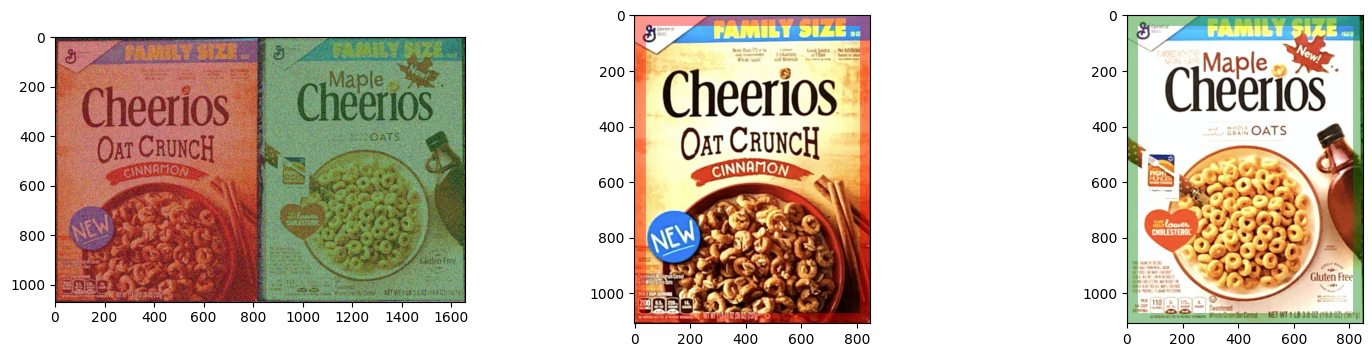

INFO:__main__:Invalid for density 0.2667*1.1237 = 0.2997
INFO:__main__:Matched density: 0.2889 * 1.4101 = 0.4074
INFO:__main__:Invalid for area 7499.0000 < 87894.4000
INFO:__main__:Invalid for area 3.5000 < 87894.4000
INFO:__main__:Invalid for color 56.6819 | 0.3944
INFO:__main__:Product 1 - Scene 2 - No match found
INFO:__main__:Invalid for density 0.2264*1.0860 = 0.2459
INFO:__main__:Invalid for density 0.2264*1.0870 = 0.2461
INFO:__main__:Invalid for density 0.2453*1.1857 = 0.2908
INFO:__main__:Product 2 - Scene 2 - No match found
INFO:__main__:Matched density: 0.9091 * 1.0000 = 0.9091
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for area 196.7266 < 87894.4000
INFO:__main__:Matched absolute color: 31.4796


Product 3 - Scene 2 - 1 instance found:
Instance 1 {position: (3, 24), width: 604px, height: 939px}


INFO:__main__:Matched density: 0.7059 * 1.0000 = 0.7059
INFO:__main__:Invalid for area 319.0820 < 87894.4000
INFO:__main__:Invalid for area 2.1211 < 87894.4000
INFO:__main__:Invalid for area 0.0039 < 87894.4000
INFO:__main__:Matched absolute color: 32.5761


Product 4 - Scene 2 - 1 instance found:
Instance 1 {position: (611, 7), width: 632px, height: 950px}


INFO:__main__:Matched density: 0.9556 * 1.0000 = 0.9556
INFO:__main__:Invalid for area 67.9688 < 87894.4000
INFO:__main__:Invalid for area 0.4688 < 87894.4000
INFO:__main__:Invalid for area 1651.0312 < 87894.4000
INFO:__main__:Matched absolute color: 31.9728


Product 5 - Scene 2 - 1 instance found:
Instance 1 {position: (1247, 28), width: 561px, height: 843px}


INFO:__main__:Invalid for density 0.1667*1.4159 = 0.2360
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for overflow
INFO:__main__:Product 6 - Scene 2 - No match found
INFO:__main__:Invalid for density 0.1000*1.1848 = 0.1185
INFO:__main__:Invalid for area 32600.5000 < 87894.4000
INFO:__main__:Invalid for overflow
INFO:__main__:Product 7 - Scene 2 - No match found
INFO:__main__:Invalid for density 0.2400*1.1694 = 0.2807
INFO:__main__:Invalid for density 0.2400*1.1648 = 0.2796
INFO:__main__:Invalid for density 0.2000*1.3235 = 0.2647
INFO:__main__:Product 8 - Scene 2 - No match found
INFO:__main__:Invalid for density 0.1579*1.0675 = 0.1685
INFO:__main__:Invalid for area 2969.1875 < 87894.4000
INFO:__main__:Invalid for area 91.1250 < 87894.4000
INFO:__main__:Product 9 - Scene 2 - No match found
INFO:__main__:Matched density: 0.4074 * 1.0837 = 0.4415
INFO:__main__:Invalid for area 98.6406 < 87894.4000
INFO:__main__:Invalid for area 138.1562 < 87894.4000
INFO:__main__:Invalid for a

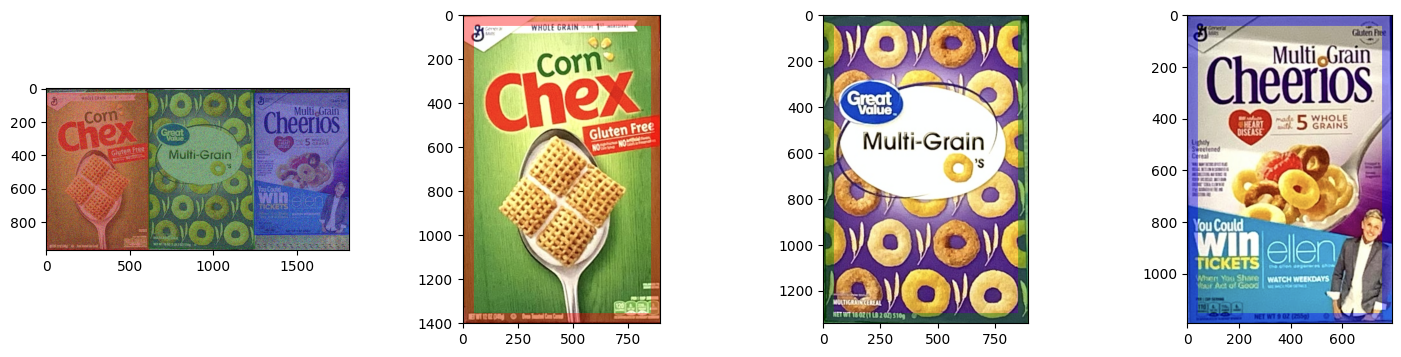

INFO:__main__:Invalid for area 5.0000 < 69441.0000
INFO:__main__:Invalid for area 91.8750 < 69441.0000
INFO:__main__:Invalid for area 368.7812 < 69441.0000
INFO:__main__:Product 1 - Scene 3 - No match found
INFO:__main__:Invalid for area 39.0625 < 69441.0000
INFO:__main__:Invalid for area 41.7188 < 69441.0000
INFO:__main__:Invalid for area 4.3438 < 69441.0000
INFO:__main__:Product 2 - Scene 3 - No match found
INFO:__main__:Invalid for density 0.2500*1.0792 = 0.2698
INFO:__main__:Invalid for density 0.2727*1.0523 = 0.2870
INFO:__main__:Invalid for overflow
INFO:__main__:Product 3 - Scene 3 - No match found
INFO:__main__:Invalid for area 0.1250 < 69441.0000
INFO:__main__:Invalid for area 1.8750 < 69441.0000
INFO:__main__:Invalid for area 3.8750 < 69441.0000
INFO:__main__:Product 4 - Scene 3 - No match found
INFO:__main__:Invalid for area 1186.2500 < 69441.0000
INFO:__main__:Invalid for area 142.7500 < 69441.0000
INFO:__main__:Invalid for area 11.8750 < 69441.0000
INFO:__main__:Product 5 

Product 6 - Scene 3 - 1 instance found:
Instance 1 {position: (-1, 122), width: 601px, height: 671px}


INFO:__main__:Matched density: 0.8000 * 1.0000 = 0.8000
INFO:__main__:Invalid for density 0.1000*1.0156 = 0.1016
INFO:__main__:Matched density: 0.4000 * 1.0415 = 0.4166
INFO:__main__:Invalid for area 83.3750 < 69441.0000
INFO:__main__:Invalid for area 1.3750 < 69441.0000
INFO:__main__:Matched absolute color: 32.4840


Product 7 - Scene 3 - 1 instance found:
Instance 1 {position: (619, 135), width: 540px, height: 649px}


INFO:__main__:Matched density: 0.8800 * 1.0000 = 0.8800
INFO:__main__:Invalid for density 0.0800*1.0528 = 0.0842
INFO:__main__:Invalid for area 943.1719 < 69441.0000
INFO:__main__:Invalid for area 0.0469 < 69441.0000
INFO:__main__:Matched absolute color: 30.3265


Product 8 - Scene 3 - 1 instance found:
Instance 1 {position: (1166, 8), width: 560px, height: 779px}


INFO:__main__:Invalid for area 68.7500 < 69441.0000
INFO:__main__:Invalid for area 9.3750 < 69441.0000
INFO:__main__:Invalid for area 4796.7500 < 69441.0000
INFO:__main__:Product 9 - Scene 3 - No match found
INFO:__main__:Invalid for density 0.2222*1.0578 = 0.2351
INFO:__main__:Invalid for density 0.2593*1.0610 = 0.2751
INFO:__main__:Invalid for density 0.3704*1.0046 = 0.3721
INFO:__main__:Product 10 - Scene 3 - No match found
INFO:__main__:Invalid for area 3498.0625 < 69441.0000
INFO:__main__:Invalid for density 0.0909*1.4117 = 0.1283
INFO:__main__:Invalid for area 2805.8750 < 69441.0000
INFO:__main__:Product 11 - Scene 3 - No match found
INFO:__main__:Invalid for area 30211.2188 < 69441.0000
INFO:__main__:Invalid for area 16480.0312 < 69441.0000
INFO:__main__:Invalid for area 1570.9609 < 69441.0000
INFO:__main__:Product 12 - Scene 3 - No match found
INFO:__main__:Invalid for area 15749.1250 < 69441.0000
INFO:__main__:Invalid for area 13885.9688 < 69441.0000
INFO:__main__:Invalid for 

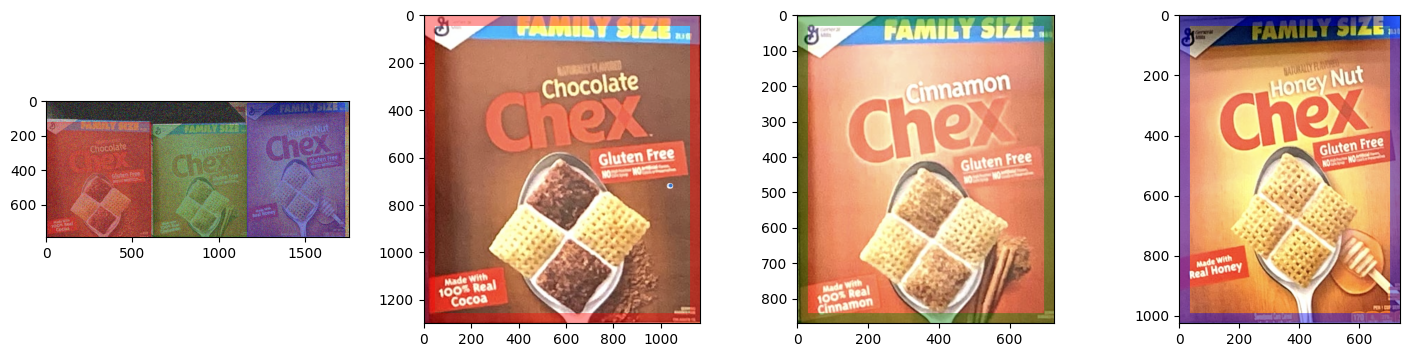

INFO:__main__:Matched density: 0.8222 * 1.0000 = 0.8222
INFO:__main__:Invalid for area 124.3125 < 64335.2000
INFO:__main__:Invalid for area 18.0625 < 64335.2000
INFO:__main__:Invalid for area 26596.1250 < 64335.2000
INFO:__main__:Matched absolute color: 36.6400


Product 1 - Scene 4 - 1 instance found:
Instance 1 {position: (699, 659), width: 374px, height: 508px}


INFO:__main__:Invalid for density 0.1132*1.0425 = 0.1180
INFO:__main__:Invalid for area 58081.1641 < 64335.2000
INFO:__main__:Invalid for overflow
INFO:__main__:Product 2 - Scene 4 - No match found
INFO:__main__:Invalid for area 9887.7109 < 64335.2000
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for overflow
INFO:__main__:Product 3 - Scene 4 - No match found
INFO:__main__:Invalid for area 2.4844 < 64335.2000
INFO:__main__:Invalid for area 2.3750 < 64335.2000
INFO:__main__:Invalid for area 13.0625 < 64335.2000
INFO:__main__:Product 4 - Scene 4 - No match found
INFO:__main__:Invalid for area 0.0000 < 64335.2000
INFO:__main__:Invalid for area 8.8125 < 64335.2000
INFO:__main__:Invalid for area 20.9531 < 64335.2000
INFO:__main__:Product 5 - Scene 4 - No match found
INFO:__main__:Invalid for area 56.2188 < 64335.2000
INFO:__main__:Invalid for area 12.8750 < 64335.2000
INFO:__main__:Invalid for area 9.0000 < 64335.2000
INFO:__main__:Product 6 - Scene 4 - No match found
INFO:__main

Product 7 - Scene 4 - 1 instance found:
Instance 1 {position: (-209, 81), width: 375px, height: 422px}


INFO:__main__:Matched density: 0.5200 * 1.0000 = 0.5200
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for area 17215.8750 < 64335.2000
INFO:__main__:Matched absolute color: 33.3364


Product 8 - Scene 4 - 1 instance found:
Instance 1 {position: (175, 13), width: 349px, height: 487px}


INFO:__main__:Matched density: 0.5263 * 1.0060 = 0.5295
INFO:__main__:Invalid for area 28.6562 < 64335.2000
INFO:__main__:Invalid for area 15.1875 < 64335.2000
INFO:__main__:Invalid for area 177.2578 < 64335.2000
INFO:__main__:Matched absolute color: 35.4647


Product 9 - Scene 4 - 1 instance found:
Instance 1 {position: (10, 710), width: 329px, height: 465px}


INFO:__main__:Invalid for density 0.2963*1.0000 = 0.2963
INFO:__main__:Invalid for density 0.3333*1.0000 = 0.3333
INFO:__main__:Matched density: 0.4074 * 1.0000 = 0.4074
INFO:__main__:Invalid for overflow
INFO:__main__:Matched absolute color: 37.1814


Product 10 - Scene 4 - 1 instance found:
Instance 1 {position: (807, 88), width: 262px, height: 406px}


INFO:__main__:Invalid for area 17.2188 < 64335.2000
INFO:__main__:Invalid for area 0.4375 < 64335.2000
INFO:__main__:Invalid for area 0.0625 < 64335.2000
INFO:__main__:Product 11 - Scene 4 - No match found
INFO:__main__:Invalid for area 29950.7500 < 64335.2000
INFO:__main__:Invalid for area 3.4688 < 64335.2000
INFO:__main__:Product 12 - Scene 4 - No match found
INFO:__main__:Invalid for area 1.6484 < 64335.2000
INFO:__main__:Invalid for area 14.8438 < 64335.2000
INFO:__main__:Invalid for area 853.4766 < 64335.2000
INFO:__main__:Product 13 - Scene 4 - No match found
INFO:__main__:Invalid for density 0.1429*1.0029 = 0.1433
INFO:__main__:Invalid for area 0.8125 < 64335.2000
INFO:__main__:Invalid for area 866.3281 < 64335.2000
INFO:__main__:Product 14 - Scene 4 - No match found


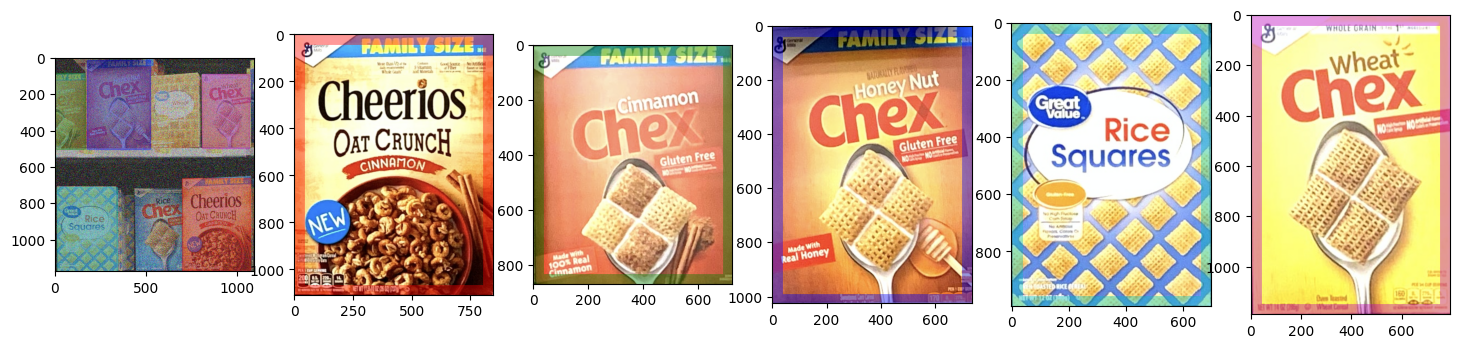

INFO:__main__:Invalid for area 0.3750 < 68065.2000
INFO:__main__:Invalid for area 2.6250 < 68065.2000
INFO:__main__:Invalid for area 0.0000 < 68065.2000
INFO:__main__:Product 1 - Scene 5 - No match found
INFO:__main__:Invalid for area 53.1250 < 68065.2000
INFO:__main__:Invalid for area 0.0000 < 68065.2000
INFO:__main__:Invalid for area 0.0000 < 68065.2000
INFO:__main__:Product 2 - Scene 5 - No match found
INFO:__main__:Invalid for area 33364.7500 < 68065.2000
INFO:__main__:Invalid for area 40.5000 < 68065.2000
INFO:__main__:Invalid for area 59.6250 < 68065.2000
INFO:__main__:Product 3 - Scene 5 - No match found
INFO:__main__:Invalid for area 9.8750 < 68065.2000
INFO:__main__:Invalid for area 42.2500 < 68065.2000
INFO:__main__:Invalid for area 0.0625 < 68065.2000
INFO:__main__:Product 4 - Scene 5 - No match found
INFO:__main__:Invalid for area 36.8125 < 68065.2000
INFO:__main__:Invalid for area 1343.1250 < 68065.2000
INFO:__main__:Invalid for area 972.3750 < 68065.2000
INFO:__main__:Pro

Product 11 - Scene 5 - 1 instance found:
Instance 1 {position: (185, 475), width: 366px, height: 553px}


INFO:__main__:Matched density: 0.6250 * 1.0000 = 0.6250
INFO:__main__:Invalid for area 40466.9922 < 68065.2000
INFO:__main__:Invalid for area 1.0723 < 68065.2000
INFO:__main__:Invalid for area 0.0039 < 68065.2000
INFO:__main__:Matched absolute color: 37.9896


Product 12 - Scene 5 - 1 instance found:
Instance 1 {position: (496, 417), width: 435px, height: 647px}


INFO:__main__:Invalid for area 2.5625 < 68065.2000
INFO:__main__:Invalid for area 6.5000 < 68065.2000
INFO:__main__:Invalid for area 0.5000 < 68065.2000
INFO:__main__:Product 13 - Scene 5 - No match found
INFO:__main__:Invalid for area 0.6250 < 68065.2000
INFO:__main__:Invalid for area 0.0000 < 68065.2000
INFO:__main__:Invalid for area 0.5625 < 68065.2000
INFO:__main__:Product 14 - Scene 5 - No match found


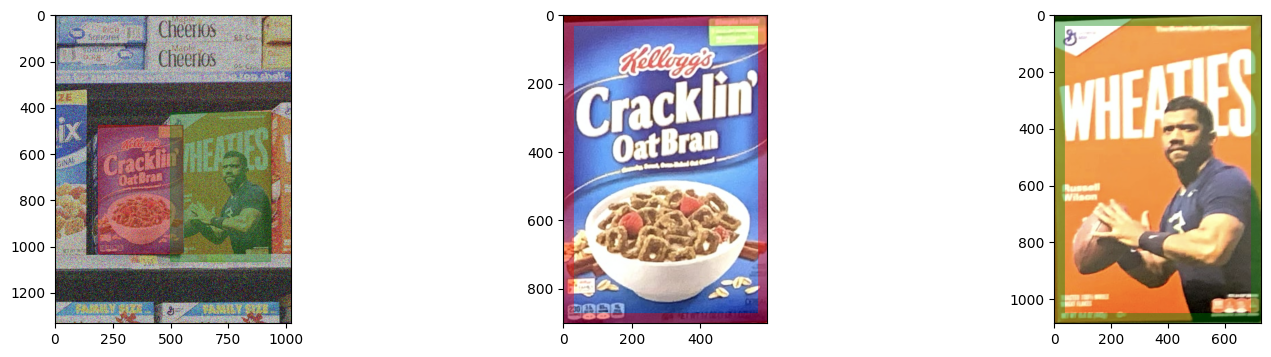

INFO:__main__:Correctness scene1: 2/2 (0 mistakes, 0 missing, 0 exceedings)
INFO:__main__:Correctness scene2: 3/3 (0 mistakes, 0 missing, 0 exceedings)
INFO:__main__:Correctness scene3: 3/3 (0 mistakes, 0 missing, 0 exceedings)
INFO:__main__:Correctness scene4: 5/5 (0 mistakes, 0 missing, 0 exceedings)
INFO:__main__:Correctness scene5: 2/2 (0 mistakes, 0 missing, 0 exceedings)


In [21]:
predictions_single = { idx: {} for idx in SINGLE_INSTANCE_SCENE_IDXS }
plot_data_single = { idx: {} for idx in SINGLE_INSTANCE_SCENE_IDXS }

for scene_idx, scene in zip(SINGLE_INSTANCE_SCENE_IDXS, single_instance_scenes):
    scene_keypoints = filterKeypoints(scene)
    scene_color = filterColor(scene)

    for template_idx, template_features in zip(SINGLE_INSTANCE_TEMPLATE_IDXS, single_templates_features):
        # if template_idx not in single_instance_ground_truth[scene_idx].keys(): continue
        object_vertexes = singleInstanceDetection(scene_keypoints.copy(), scene_color, template_features)
        
        if object_vertexes is None: 
            logger.info(f"Product {template_idx} - Scene {scene_idx} - No match found")
            continue

        printResults(scene_idx, template_idx, [object_vertexes])
        predictions_single[scene_idx][template_idx] = 1
        plot_data_single[scene_idx][template_idx] = (object_vertexes, template_features.image)

    if SHOW_PLOTS:
        num_detections = len(plot_data_single[scene_idx])
        plt.figure(figsize=(18, 4))
        plt.subplot(1, 1+num_detections, 1)
        plt.imshow(scene)
        for i, template_idx in enumerate(plot_data_single[scene_idx]):
            top_left, width, height = formatResultBox(plot_data_single[scene_idx][template_idx][0])
            plt.gca().add_patch( patches.Rectangle(top_left, width, height, linewidth=1, fill=True, alpha=0.3, color=getRandomColor(i)) )
        for i, template_idx in enumerate(plot_data_single[scene_idx]):
            image = plot_data_single[scene_idx][template_idx][1]
            plt.subplot(1, 1+num_detections, 2+i)
            plt.imshow(image)
            plt.gca().add_patch( patches.Rectangle((0, 0), image.shape[1], image.shape[0], linewidth=15, fill=False, alpha=0.4, color=getRandomColor(i)) )
        plt.show()

evaluate(predictions_single, single_instance_ground_truth)

## Multiple instances detection

In [22]:
def multiInstanceDetection(scene_keypoints, scene_color, template_features):
    detections = []
    candidates = findCandidateInstances(
        scene_keypoints.copy(), scene_color, template_features,
        to_try_thresholds = np.arange(0.7, 0.8, 0.05),
        density_threshold = 0.2
    )
    if len(candidates) == 0: return []
    detections = colorComparisonMultiInstance(candidates)

    return [ d.vertexes for d in detections ]

In [23]:
multi_templates_features = [
    TemplateFeatures(template, color_window_size=25, color_bins=None)
    for template in multi_instance_templates
]

INFO:__main__:Matched density: 0.7273 * 1.0031 = 0.7295
INFO:__main__:Matched density: 0.7273 * 1.0000 = 0.7273
INFO:__main__:Matched density: 0.3636 * 1.0001 = 0.3637
INFO:__main__:Matched density: 0.4545 * 1.0286 = 0.4676
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for area 1.7500 < 81150.4000
INFO:__main__:Invalid for area 17927.0000 < 81150.4000
INFO:__main__:Matched color absolute score: 30.5426 | Affine: 0.8393
INFO:__main__:Matched color absolute score: 32.5088 | Affine: 0.8114


Product 15 - Scene 6 - 2 instance found:
Instance 1 {position: (420, 168), width: 325px, height: 905px}
Instance 2 {position: (21, 165), width: 332px, height: 902px}


INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for area 8277.7734 < 81150.4000
INFO:__main__:Invalid for area 22.8750 < 81150.4000
INFO:__main__:Product 16 - Scene 6 - No match found
INFO:__main__:Invalid for area 35.1250 < 81150.4000
INFO:__main__:Invalid for area 75.7500 < 81150.4000
INFO:__main__:Invalid for area 2.1250 < 81150.4000
INFO:__main__:Product 17 - Scene 6 - No match found
INFO:__main__:Invalid for area 15.6406 < 81150.4000
INFO:__main__:Invalid for overflow
INFO:__main__:Product 18 - Scene 6 - No match found
INFO:__main__:Invalid for area 33361.4375 < 81150.4000
INFO:__main__:Invalid for area 3352.5625 < 81150.4000
INFO:__main__:Product 19 - Scene 6 - No match found
INFO:__main__:Invalid for area 0.1250 < 81150.4000
INFO:__main__:Invalid for area 1059.0391 < 81150.4000
INFO:__main__:Product 20 - Scene 6 - No match found
INFO:__main__:Invalid for area 2451.3750 < 81150.4000
INFO:__main__:Invalid for area 52.8750 < 81150.4000
INFO:__main__:Invalid for area 660.25

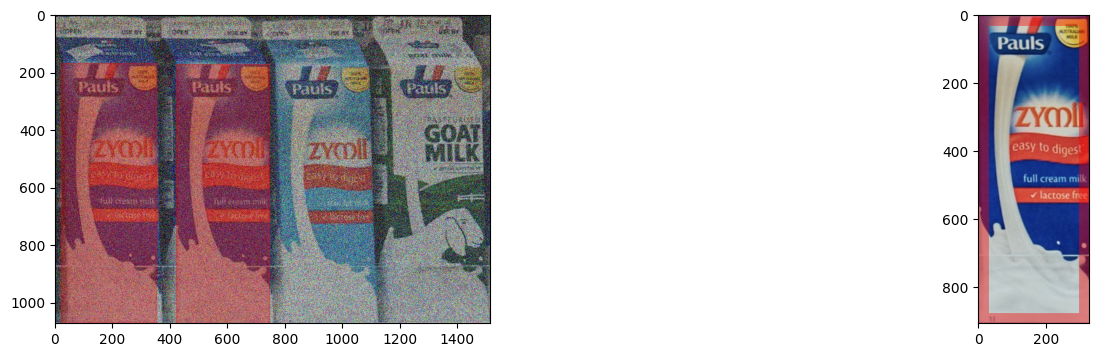

INFO:__main__:Invalid for area 3717.7500 < 43891.8000
INFO:__main__:Invalid for area 100.2500 < 43891.8000
INFO:__main__:Invalid for area 2610.3125 < 43891.8000
INFO:__main__:Product 15 - Scene 7 - No match found
INFO:__main__:Matched density: 0.6190 * 1.0000 = 0.6190
INFO:__main__:Matched density: 0.5238 * 1.0000 = 0.5238
INFO:__main__:Invalid for area 1.6797 < 43891.8000
INFO:__main__:Invalid for area 341.1250 < 43891.8000
INFO:__main__:Invalid for area 0.0000 < 43891.8000
INFO:__main__:Matched color absolute score: 33.2873 | Affine: 0.6386
INFO:__main__:Matched color absolute score: 34.0741 | Affine: 0.8682


Product 16 - Scene 7 - 2 instance found:
Instance 1 {position: (687, 162), width: 215px, height: 599px}
Instance 2 {position: (922, 162), width: 216px, height: 599px}


INFO:__main__:Invalid for area 156.4375 < 43891.8000
INFO:__main__:Invalid for area 5969.1250 < 43891.8000
INFO:__main__:Invalid for area 2.7188 < 43891.8000
INFO:__main__:Product 17 - Scene 7 - No match found
INFO:__main__:Invalid for area 3838.1875 < 43891.8000
INFO:__main__:Product 18 - Scene 7 - No match found
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for area 248.3750 < 43891.8000
INFO:__main__:Invalid for area 40.1250 < 43891.8000
INFO:__main__:Product 19 - Scene 7 - No match found
INFO:__main__:Invalid for area 2827.2344 < 43891.8000
INFO:__main__:Invalid for area 18.4375 < 43891.8000
INFO:__main__:Invalid for area 92.2500 < 43891.8000
INFO:__main__:Product 20 - Scene 7 - No match found
INFO:__main__:Invalid for area 14.5000 < 43891.8000
INFO:__main__:Invalid for area 62.4688 < 43891.8000
INFO:__main__:Product 21 - Scene 7 - No match found
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for area 2061.2500 < 43891.8000
INFO:__main__:Invalid for area 251.62

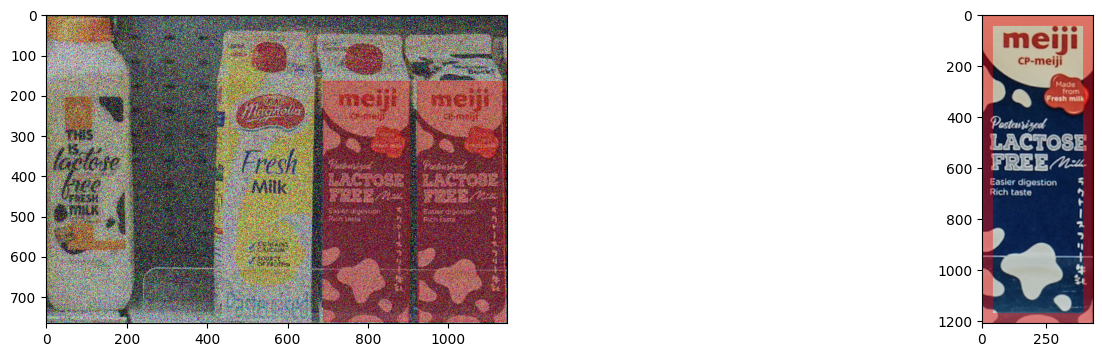

INFO:__main__:Invalid for area 494.4180 < 76252.8000
INFO:__main__:Invalid for overflow
INFO:__main__:Product 15 - Scene 8 - No match found
INFO:__main__:Invalid for area 0.0000 < 76252.8000
INFO:__main__:Invalid for area 0.2656 < 76252.8000
INFO:__main__:Invalid for area 0.0977 < 76252.8000
INFO:__main__:Product 16 - Scene 8 - No match found
INFO:__main__:Matched density: 0.6000 * 1.0000 = 0.6000
INFO:__main__:Matched density: 0.6000 * 1.0000 = 0.6000
INFO:__main__:Matched density: 0.7000 * 1.0125 = 0.7088
INFO:__main__:Invalid for area 35.2812 < 76252.8000
INFO:__main__:Invalid for area 2251.0156 < 76252.8000
INFO:__main__:Invalid for area 0.0312 < 76252.8000
INFO:__main__:Matched color absolute score: 29.5948 | Affine: 0.3311
INFO:__main__:Matched color absolute score: 30.4434 | Affine: 0.8228


Product 17 - Scene 8 - 2 instance found:
Instance 1 {position: (486, 140), width: 324px, height: 854px}
Instance 2 {position: (825, 149), width: 325px, height: 853px}


INFO:__main__:Matched density: 0.8571 * 1.0000 = 0.8571
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for overflow
INFO:__main__:Product 18 - Scene 8 - No match found
INFO:__main__:Invalid for area 11.5000 < 76252.8000
INFO:__main__:Invalid for overflow
INFO:__main__:Product 19 - Scene 8 - No match found
INFO:__main__:Invalid for area 3528.9062 < 76252.8000
INFO:__main__:Invalid for area 10060.1562 < 76252.8000
INFO:__main__:Product 20 - Scene 8 - No match found
INFO:__main__:Invalid for area 0.0000 < 76252.8000
INFO:__main__:Invalid for area 23883.9375 < 76252.8000
INFO:__main__:Invalid for overflow
INFO:__main__:Product 21 - Scene 8 - No match found
INFO:__main__:Invalid for area 1225.1250 < 76252.8000
INFO:__main__:Invalid for area 0.1250 < 76252.8000
INFO:__main__:Invalid for area 3.6250 < 76252.8000
INFO:__main__:Product 22 - Scene 8 - No match found
INFO:__main__:Matched density: 0.4483 * 1.0000 = 0.4483
INFO:__main__:Matched density: 0.6552 * 1.0000 = 0.6552
INFO:__ma

Product 23 - Scene 8 - 2 instance found:
Instance 1 {position: (486, 120), width: 318px, height: 860px}
Instance 2 {position: (827, 133), width: 320px, height: 869px}


INFO:__main__:Matched density: 0.6111 * 1.0000 = 0.6111
INFO:__main__:Matched density: 0.4444 * 1.0000 = 0.4444
INFO:__main__:Matched density: 0.8333 * 1.0000 = 0.8333
INFO:__main__:Invalid for area 1378.1406 < 76252.8000
INFO:__main__:Invalid for area 0.0176 < 76252.8000
INFO:__main__:Invalid for area 62.3750 < 76252.8000
INFO:__main__:Matched color absolute score: 29.6438 | Affine: 0.8996


Product 24 - Scene 8 - 1 instance found:
Instance 1 {position: (1174, 154), width: 327px, height: 852px}


INFO:__main__:Invalid for area 0.0000 < 76252.8000
INFO:__main__:Invalid for area 233.5771 < 76252.8000
INFO:__main__:Invalid for area 1749.9062 < 76252.8000
INFO:__main__:Product 25 - Scene 8 - No match found
INFO:__main__:Matched density: 1.0000 * 1.0000 = 1.0000
INFO:__main__:Invalid for area 0.1250 < 76252.8000
INFO:__main__:Invalid for area 26.0938 < 76252.8000
INFO:__main__:Invalid for area 4.0312 < 76252.8000
INFO:__main__:Matched color absolute score: 44.5335 | Affine: 0.9069


Product 26 - Scene 8 - 1 instance found:
Instance 1 {position: (114, 189), width: 293px, height: 761px}


INFO:__main__:Matched density: 1.0000 * 1.0000 = 1.0000
INFO:__main__:Matched density: 0.1250 * 2.2018 = 0.2752
INFO:__main__:Invalid for area 3.4375 < 76252.8000
INFO:__main__:Invalid for area 0.2188 < 76252.8000
INFO:__main__:Product 27 - Scene 8 - No match found


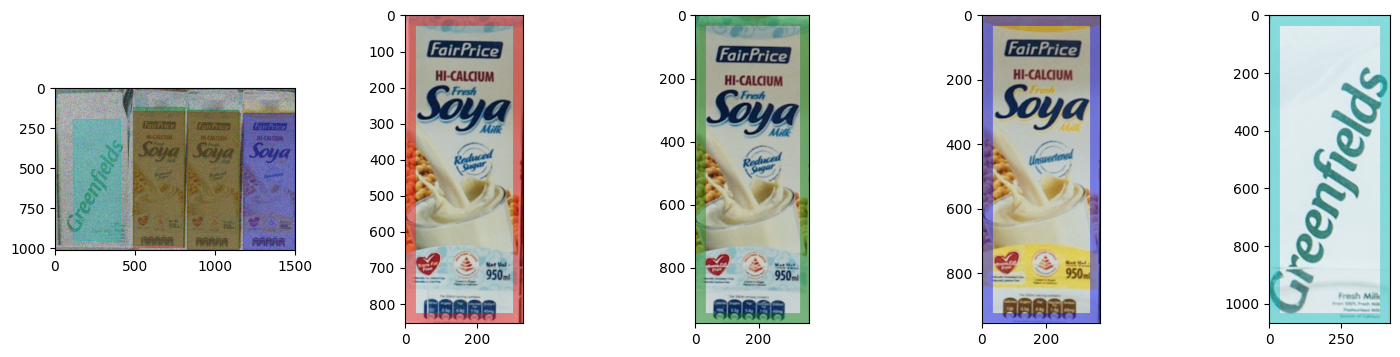

INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for area 456.6504 < 49252.8000
INFO:__main__:Invalid for area 0.2188 < 49252.8000
INFO:__main__:Product 15 - Scene 9 - No match found
INFO:__main__:Invalid for area 118.1875 < 49252.8000
INFO:__main__:Invalid for area 1.0625 < 49252.8000
INFO:__main__:Invalid for area 2024.8750 < 49252.8000
INFO:__main__:Product 16 - Scene 9 - No match found
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for area 120.3672 < 49252.8000
INFO:__main__:Product 17 - Scene 9 - No match found
INFO:__main__:Matched density: 0.2857 * 1.0000 = 0.2857
INFO:__main__:Matched density: 0.2857 * 1.0227 = 0.2922
INFO:__main__:Invalid for area 1317.9619 < 49252.8000
INFO:__main__:Invalid for area 111.0000 < 49252.8000
INFO:__main__:Matched color absolute score: 35.0199 | Affine: 0.5834
INFO:__main__:Matched color absolute score: 34.9918 | Affine: 0.5545


Product 18 - Scene 9 - 2 instance found:
Instance 1 {position: (254, 109), width: 229px, height: 547px}
Instance 2 {position: (0, 90), width: 214px, height: 547px}


INFO:__main__:Matched density: 0.6667 * 1.0015 = 0.6677
INFO:__main__:Matched density: 0.6667 * 1.0000 = 0.6667
INFO:__main__:Invalid for overflow
INFO:__main__:Matched color absolute score: 39.7132 | Affine: 0.7535
INFO:__main__:Matched color absolute score: 34.2718 | Affine: 0.8181


Product 19 - Scene 9 - 2 instance found:
Instance 1 {position: (742, 100), width: 219px, height: 560px}
Instance 2 {position: (511, 96), width: 218px, height: 556px}


INFO:__main__:Matched density: 0.2308 * 1.0012 = 0.2310
INFO:__main__:Matched density: 0.3846 * 1.0011 = 0.3850
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for overflow
INFO:__main__:Matched color absolute score: 32.1545 | Affine: 0.7781
INFO:__main__:Matched color absolute score: 35.9562 | Affine: 0.2515


Product 20 - Scene 9 - 2 instance found:
Instance 1 {position: (1251, 99), width: 222px, height: 558px}
Instance 2 {position: (988, 97), width: 231px, height: 554px}


INFO:__main__:Invalid for area 16.9062 < 49252.8000
INFO:__main__:Invalid for area 20881.7500 < 49252.8000
INFO:__main__:Invalid for area 9637.0625 < 49252.8000
INFO:__main__:Product 21 - Scene 9 - No match found
INFO:__main__:Invalid for area 5697.9375 < 49252.8000
INFO:__main__:Invalid for area 6.0156 < 49252.8000
INFO:__main__:Invalid for area 12.2969 < 49252.8000
INFO:__main__:Product 22 - Scene 9 - No match found
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for area 2506.9688 < 49252.8000
INFO:__main__:Product 23 - Scene 9 - No match found
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for area 1938.3750 < 49252.8000
INFO:__main__:Product 24 - Scene 9 - No match found
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for overflow
INFO:__main__:Product 25 - Scene 9 - No match found
INFO:__main__:Invalid for area 499.6797 < 49252.8000
INFO:__main__:Matched density: 0.4167 * 1.0016 = 0.4173
INFO:__main__:Invalid for area

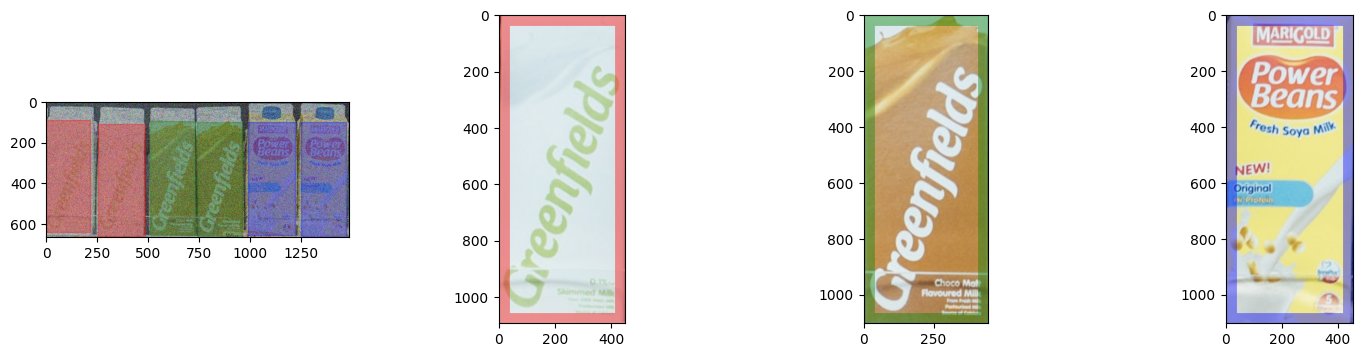

INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for area 532.0000 < 79033.6000
INFO:__main__:Product 15 - Scene 10 - No match found
INFO:__main__:Invalid for area 13757.3750 < 79033.6000
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for area 1933.6875 < 79033.6000
INFO:__main__:Product 16 - Scene 10 - No match found
INFO:__main__:Invalid for area 8.2500 < 79033.6000
INFO:__main__:Invalid for area 5945.2812 < 79033.6000
INFO:__main__:Invalid for area 98.8125 < 79033.6000
INFO:__main__:Product 17 - Scene 10 - No match found
INFO:__main__:Invalid for area 18344.0625 < 79033.6000
INFO:__main__:Invalid for density 0.1429*1.2557 = 0.1794
INFO:__main__:Product 18 - Scene 10 - No match found
INFO:__main__:Invalid for area 0.0938 < 79033.6000
INFO:__main__:Invalid for area 0.0938 < 79033.6000
INFO:__main__:Product 19 - Scene 10 - No match found
INFO:__main__:Invalid for area 141.8125 < 79033.6000
INFO:__main__:Invalid for area 6139.6250 < 79033.6000
INFO:__main__:Invalid for

Product 21 - Scene 10 - 2 instance found:
Instance 1 {position: (589, 187), width: 244px, height: 685px}
Instance 2 {position: (854, 192), width: 255px, height: 702px}


INFO:__main__:Matched density: 0.4286 * 1.0000 = 0.4286
INFO:__main__:Matched density: 0.4286 * 1.0000 = 0.4286
INFO:__main__:Invalid for area 14187.2500 < 79033.6000
INFO:__main__:Matched density: 0.5714 * 1.0000 = 0.5714
INFO:__main__:Matched density: 0.7143 * 1.0000 = 0.7143
INFO:__main__:Invalid for area 12021.7598 < 79033.6000
INFO:__main__:Invalid for area 45393.3750 < 79033.6000
INFO:__main__:Matched color absolute score: 31.5255 | Affine: 0.9138
INFO:__main__:Matched color absolute score: 35.7664 | Affine: 0.9210


Product 22 - Scene 10 - 2 instance found:
Instance 1 {position: (1142, 194), width: 243px, height: 693px}
Instance 2 {position: (1403, 187), width: 246px, height: 695px}


INFO:__main__:Invalid for area 3364.5000 < 79033.6000
INFO:__main__:Invalid for area 7551.0625 < 79033.6000
INFO:__main__:Invalid for area 13839.3555 < 79033.6000
INFO:__main__:Product 23 - Scene 10 - No match found
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for area 8954.4062 < 79033.6000
INFO:__main__:Invalid for overflow
INFO:__main__:Product 24 - Scene 10 - No match found
INFO:__main__:Invalid for area 7285.3750 < 79033.6000
INFO:__main__:Invalid for area 2.3750 < 79033.6000
INFO:__main__:Invalid for area 1.1250 < 79033.6000
INFO:__main__:Product 25 - Scene 10 - No match found
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for area 401.8125 < 79033.6000
INFO:__main__:Invalid for area 169.1250 < 79033.6000
INFO:__main__:Product 26 - Scene 10 - No match found
INFO:__main__:Invalid for area 529.6250 < 79033.6000
INFO:__main__:Invalid for area 52861.6250 < 79033.6000
INFO:__main__:Invalid for overflow
INFO:__main__:Product 27 - Scene 10 - No match found


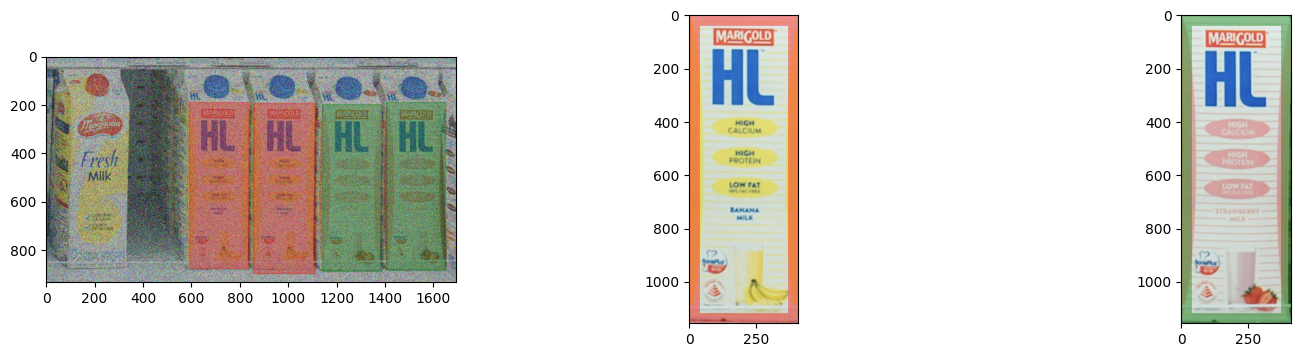

INFO:__main__:Invalid for overflow
INFO:__main__:Product 15 - Scene 11 - No match found
INFO:__main__:Invalid for area 0.5156 < 49943.4000
INFO:__main__:Invalid for area 29.3125 < 49943.4000
INFO:__main__:Invalid for area 55.7969 < 49943.4000
INFO:__main__:Product 16 - Scene 11 - No match found
INFO:__main__:Invalid for density 0.1000*1.0000 = 0.1000
INFO:__main__:Invalid for density 0.1667*1.0000 = 0.1667
INFO:__main__:Matched density: 0.2667 * 1.0000 = 0.2667
INFO:__main__:Matched density: 0.2333 * 1.0000 = 0.2333
INFO:__main__:Matched density: 0.2333 * 1.0000 = 0.2333
INFO:__main__:Matched density: 0.3333 * 1.0000 = 0.3333
INFO:__main__:Invalid for overflow
INFO:__main__:Matched color absolute score: 30.7223 | Affine: 0.9314
INFO:__main__:Matched color absolute score: 31.9181 | Affine: 0.7102


Product 17 - Scene 11 - 2 instance found:
Instance 1 {position: (74, 120), width: 184px, height: 483px}
Instance 2 {position: (264, 126), width: 182px, height: 470px}


INFO:__main__:Invalid for area 858.1250 < 49943.4000
INFO:__main__:Product 18 - Scene 11 - No match found
INFO:__main__:Invalid for area 0.0000 < 49943.4000
INFO:__main__:Invalid for area 20.6406 < 49943.4000
INFO:__main__:Product 19 - Scene 11 - No match found
INFO:__main__:Invalid for area 599.0000 < 49943.4000
INFO:__main__:Invalid for area 599.0000 < 49943.4000
INFO:__main__:Invalid for area 6.6875 < 49943.4000
INFO:__main__:Product 20 - Scene 11 - No match found
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for area 21765.5000 < 49943.4000
INFO:__main__:Invalid for overflow
INFO:__main__:Product 21 - Scene 11 - No match found
INFO:__main__:Invalid for area 3792.2500 < 49943.4000
INFO:__main__:Invalid for area 108.8906 < 49943.4000
INFO:__main__:Invalid for area 819.5703 < 49943.4000
INFO:__main__:Product 22 - Scene 11 - No match found
INFO:__main__:Matched density: 0.2414 * 1.0000 = 0.2414
INFO:__main__:Matched density: 0.2069 * 1.0000 = 0.2069
INFO:__main__:Matched den

Product 23 - Scene 11 - 2 instance found:
Instance 1 {position: (72, 117), width: 183px, height: 489px}
Instance 2 {position: (265, 119), width: 183px, height: 488px}


INFO:__main__:Matched density: 0.2222 * 1.0000 = 0.2222
INFO:__main__:Invalid for overflow
INFO:__main__:Matched density: 0.3333 * 1.0000 = 0.3333
INFO:__main__:Invalid for density 0.1667*1.0000 = 0.1667
INFO:__main__:Matched density: 0.2222 * 1.0000 = 0.2222
INFO:__main__:Matched density: 0.5000 * 1.0000 = 0.5000
INFO:__main__:Invalid for overflow
INFO:__main__:Matched color absolute score: 36.0823 | Affine: 0.0795
INFO:__main__:Matched color absolute score: 31.9088 | Affine: 0.4849


Product 24 - Scene 11 - 2 instance found:
Instance 1 {position: (653, 131), width: 183px, height: 493px}
Instance 2 {position: (462, 128), width: 186px, height: 480px}


INFO:__main__:Matched density: 0.5000 * 1.0000 = 0.5000
INFO:__main__:Matched density: 0.5000 * 1.0000 = 0.5000
INFO:__main__:Matched density: 0.6667 * 1.0000 = 0.6667
INFO:__main__:Invalid for area 60.8750 < 49943.4000
INFO:__main__:Matched color absolute score: 40.3329 | Affine: 0.8095
INFO:__main__:Matched color absolute score: 37.4166 | Affine: 0.6875
INFO:__main__:Matched color absolute score: 33.3490 | Affine: 0.9013


Product 25 - Scene 11 - 3 instance found:
Instance 1 {position: (849, 126), width: 187px, height: 473px}
Instance 2 {position: (1243, 129), width: 188px, height: 453px}
Instance 3 {position: (1050, 130), width: 185px, height: 480px}


INFO:__main__:Invalid for area 420.3750 < 49943.4000
INFO:__main__:Invalid for area 17039.1562 < 49943.4000
INFO:__main__:Invalid for area 213.4688 < 49943.4000
INFO:__main__:Product 26 - Scene 11 - No match found
INFO:__main__:Invalid for area 349.4219 < 49943.4000
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for area 1202.3125 < 49943.4000
INFO:__main__:Product 27 - Scene 11 - No match found


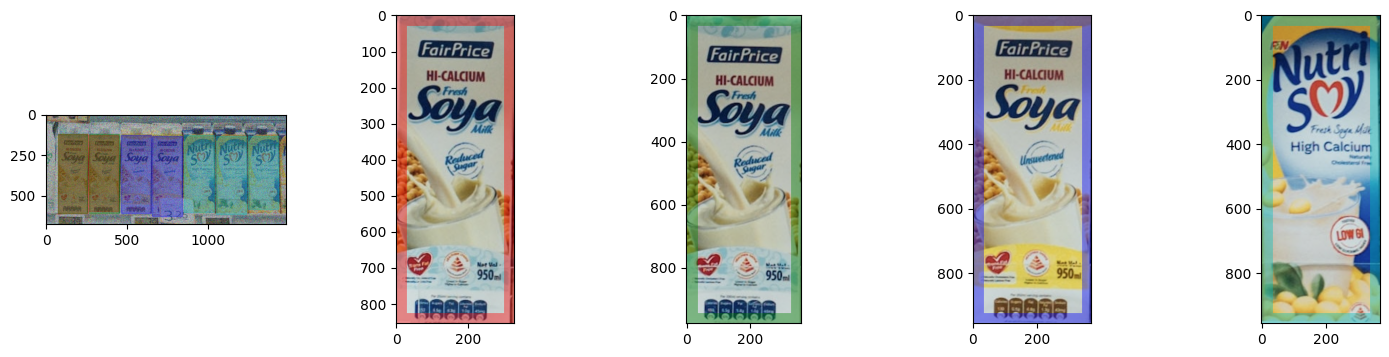

INFO:__main__:Invalid for area 27563.5469 < 57235.2000
INFO:__main__:Product 15 - Scene 12 - No match found
INFO:__main__:Invalid for area 5919.0625 < 57235.2000
INFO:__main__:Invalid for area 85.3594 < 57235.2000
INFO:__main__:Invalid for area 0.1064 < 57235.2000
INFO:__main__:Product 16 - Scene 12 - No match found
INFO:__main__:Invalid for area 14613.4375 < 57235.2000
INFO:__main__:Invalid for area 671.5000 < 57235.2000
INFO:__main__:Invalid for area 4201.1562 < 57235.2000
INFO:__main__:Product 17 - Scene 12 - No match found
INFO:__main__:Matched density: 0.5000 * 1.0000 = 0.5000
INFO:__main__:Matched density: 0.4286 * 1.0000 = 0.4286
INFO:__main__:Invalid for area 1951.3750 < 57235.2000
INFO:__main__:Invalid for overflow
INFO:__main__:Matched density: 0.2143 * 1.0000 = 0.2143
INFO:__main__:Matched density: 0.3571 * 1.0045 = 0.3587
INFO:__main__:Matched density: 0.4286 * 1.0000 = 0.4286
INFO:__main__:Matched density: 0.6429 * 1.0000 = 0.6429
INFO:__main__:Invalid for area 3469.0801 <

Product 18 - Scene 12 - 2 instance found:
Instance 1 {position: (1359, 103), width: 240px, height: 596px}
Instance 2 {position: (1084, 99), width: 242px, height: 586px}


INFO:__main__:Invalid for area 2751.8906 < 57235.2000
INFO:__main__:Invalid for area 1603.5156 < 57235.2000
INFO:__main__:Product 19 - Scene 12 - No match found
INFO:__main__:Invalid for overflow
INFO:__main__:Product 20 - Scene 12 - No match found
INFO:__main__:Invalid for area 1916.2500 < 57235.2000
INFO:__main__:Product 21 - Scene 12 - No match found
INFO:__main__:Invalid for area 42052.5000 < 57235.2000
INFO:__main__:Invalid for area 205.8828 < 57235.2000
INFO:__main__:Invalid for area 0.0469 < 57235.2000
INFO:__main__:Product 22 - Scene 12 - No match found
INFO:__main__:Invalid for overflow
INFO:__main__:Invalid for area 7774.6875 < 57235.2000
INFO:__main__:Invalid for area 0.6562 < 57235.2000
INFO:__main__:Product 23 - Scene 12 - No match found
INFO:__main__:Invalid for area 122.5000 < 57235.2000
INFO:__main__:Invalid for area 21860.7422 < 57235.2000
INFO:__main__:Product 24 - Scene 12 - No match found
INFO:__main__:Invalid for overflow
INFO:__main__:Product 25 - Scene 12 - No ma

Product 26 - Scene 12 - 2 instance found:
Instance 1 {position: (13, 65), width: 226px, height: 597px}
Instance 2 {position: (292, 104), width: 230px, height: 580px}


INFO:__main__:Matched density: 0.6250 * 1.0000 = 0.6250
INFO:__main__:Matched density: 0.5000 * 1.0000 = 0.5000
INFO:__main__:Matched density: 0.5000 * 1.0000 = 0.5000
INFO:__main__:Matched density: 0.6250 * 1.0000 = 0.6250
INFO:__main__:Matched density: 0.5000 * 1.0484 = 0.5242
INFO:__main__:Matched density: 0.7500 * 1.0000 = 0.7500
INFO:__main__:Invalid for area 26.8750 < 57235.2000
INFO:__main__:Invalid for area 0.1250 < 57235.2000
INFO:__main__:Invalid for area 0.1250 < 57235.2000
INFO:__main__:Matched color absolute score: 33.7939 | Affine: 0.7580
INFO:__main__:Matched color absolute score: 34.2924 | Affine: 0.8523


Product 27 - Scene 12 - 2 instance found:
Instance 1 {position: (799, 74), width: 279px, height: 594px}
Instance 2 {position: (567, 95), width: 265px, height: 598px}


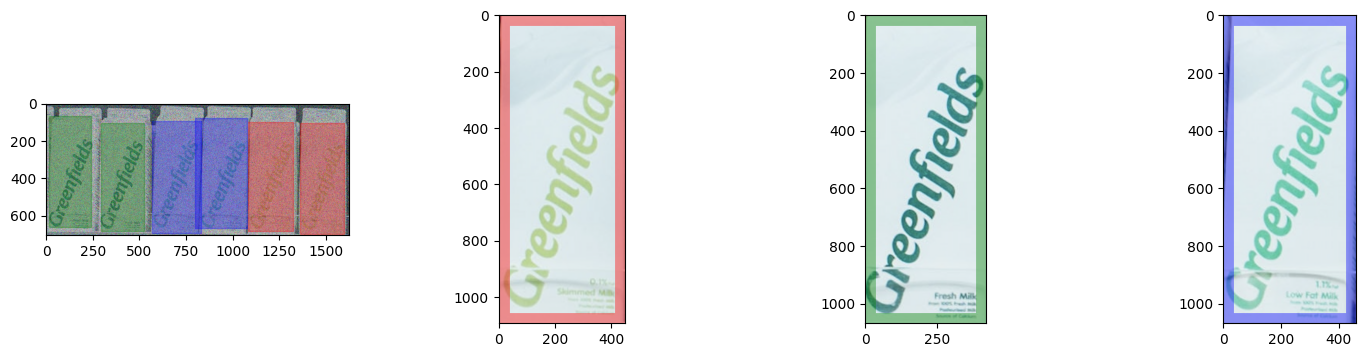

INFO:__main__:Correctness scene6: 2/2 (0 mistakes, 0 missing, 0 exceedings)
INFO:__main__:Correctness scene7: 2/2 (0 mistakes, 0 missing, 0 exceedings)
INFO:__main__:Correctness scene8: 5/6 (1 mistakes, 1 missing, 0 exceedings)
INFO:__main__:Correctness scene9: 6/6 (0 mistakes, 0 missing, 0 exceedings)
INFO:__main__:Correctness scene10: 4/4 (0 mistakes, 0 missing, 0 exceedings)
INFO:__main__:Correctness scene11: 9/9 (0 mistakes, 0 missing, 0 exceedings)
INFO:__main__:Correctness scene12: 6/6 (0 mistakes, 0 missing, 0 exceedings)


In [24]:
predictions_multi = { idx: {} for idx in MULTIPLE_INSTANCES_SCENE_IDXS }
plot_data_multi = { idx: {} for idx in MULTIPLE_INSTANCES_SCENE_IDXS }


for scene_idx, scene in zip(MULTIPLE_INSTANCES_SCENE_IDXS, multi_instance_scenes):
    scene_keypoints = filterKeypoints(scene)
    scene_color = filterColor(scene)

    for template_idx, template_features in zip(MULTIPLE_INSTANCES_TEMPLATE_IDXS, multi_templates_features):
        # if template_idx not in multi_instance_ground_truth[scene_idx]: continue
        # if template_idx not in [18, 26, 27]: continue
        instances_vertexes = multiInstanceDetection(scene_keypoints.copy(), scene_color, template_features)
        
        if len(instances_vertexes) == 0: 
            logger.info(f"Product {template_idx} - Scene {scene_idx} - No match found")
            continue
        
        printResults(scene_idx, template_idx, instances_vertexes)
        predictions_multi[scene_idx][template_idx] = len(instances_vertexes)
        plot_data_multi[scene_idx][template_idx] = (instances_vertexes, template_features.image)


    if SHOW_PLOTS:
        num_detections = len(plot_data_multi[scene_idx])
        plt.figure(figsize=(18, 4))
        plt.subplot(1, 1+num_detections, 1)
        plt.imshow(scene)
        for i, template_idx in enumerate(plot_data_multi[scene_idx]):
            for matched_vertexes in plot_data_multi[scene_idx][template_idx][0]:
                top_left, width, height = formatResultBox(matched_vertexes)
                plt.gca().add_patch( patches.Rectangle(top_left, width, height, linewidth=1, fill=True, alpha=0.3, color=getRandomColor(i)) )
        for i, template_idx in enumerate(plot_data_multi[scene_idx]):
            image = plot_data_multi[scene_idx][template_idx][1]
            plt.subplot(1, 1+num_detections, 2+i)
            plt.imshow(image)
            plt.gca().add_patch( patches.Rectangle((0, 0), image.shape[1], image.shape[0], linewidth=15, fill=False, alpha=0.4, color=getRandomColor(i)) )
        plt.show()

evaluate(predictions_multi, multi_instance_ground_truth)